# Sunny Side Sketch Challenge Problem

<img src="https://i.ibb.co/MknQ67tW/eggs.png" width="100%" style="max-width: 600px; display:block; margin:auto;">


Once upon a time, an ambitious engineer was tasked with inventing an “egg-maker” — a marvelous machine that could whip up eggs in all their delicious forms: fried, scrambled, poached, you name it. But somewhere along the way, wires got crossed (literally), and instead of producing eggs, the machine started… drawing them. Perfectly neat outlines of every egg recipe you could imagine appeared on paper, but not a single breakfast was served.
And so, the legend of the “Egg-Maker-That-Only-Makes-Egg-DRAWINGS” was born.

Your task: Design 2D planar linkage mechanisms that can trace six target egg-paths. These curves are your recipes — now go cook up some mechanisms!



In [86]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random

# deteministic random numbers
np.random.seed(0)
random.seed(0)

We have given you the outlines of eggs we want in a numpy file called `target_curves.npy` which you can load using numpy and plot using matplotlib:

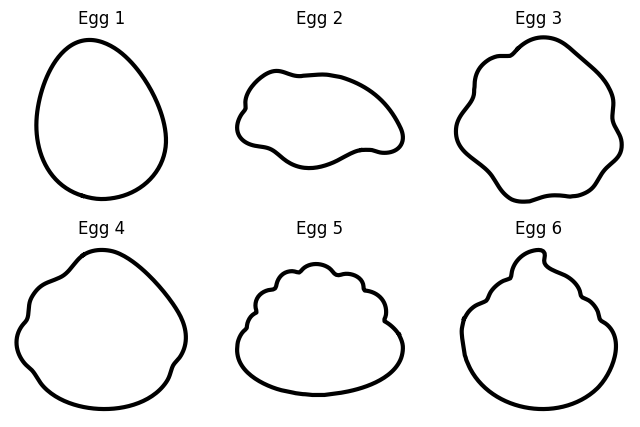

In [87]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')

<font color="red" size="8"><b>WARNING: </b></font> If you plan to work on this notebook in colab we would like to warn you that if you do not download any files you save or save the changes separately, upon the runtime being killed either by you closing the tab/browser or by timing out due to inactivity you WILL LOSE YOUR FILES AND WORK. It is highly recommeneded that you make a local python environment to work.

## Overview
The first portion of this notebook will help you understand the linkage design problem and the way we parameterize each linkage design. It will also discuss deliverables and submission instructions. In the second half of this notebook we provide you with a working implementation that you can use as a baseline. 

**IMPORTANT:** We also provide numerous helper functions in the linkage_utils. We touch on most of these functions in this notebook but some *very useful* functions will be covered in the advanced notebook!

### Project Files and Functions Provided:

All files as well as helper functions and further information can be found in the Github repository of this challenge problem:
[Github Repo](https://github.com/ahnobari/2155-Optimization-Challenge-Problem)

### The Optimization Problem
<div width="100%"><img src="https://i.imgur.com/69xDuZc.png" alt="Path Synthesis Problem" width="60%" style="margin:auto;display:block"></div>

The problem we try to solve in this challenge problem is similar to the one in the optimization demo. The goal in this problem is to design a linkage mechanism that can trace a target curve. In addition to this we also want to minimize material usage. We will discuss the full problem later in the notebook but before we get to that, let us review how we represented linkage mechanisms computationally.


### Mechanism Representation
Here we will briefly discuss how we can represent linkage mechanisms. In this demonstration we will represent linkage mechanisms as graphs. A graph is represented as a set of nodes (e.g., $N = \{1,2,3,\ldots,N\}$), and set of edges, that describe how nodes are connected to each other (e.g., $E=\{(1,2), (5,2), \ldots \}$). Graphs can also include features associated with each node (e.g., initial positions of joints in our example of mechanisms).

To see how this works take the mechanism below:

<div width="100%"><img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Path Synthesis Problem" width="40%" style="margin:auto;display:block"></div>


We can see that we have 5 joints, which we will represent as 5 nodes, $N=\{0,1,2,3,4\}$, and we can represent the linkages as edges in the graph, which give us the edges $E=\{(0,2),(1,3),(2,3),(2,4),(3,4)\}$. Note that edges in this graph do not have directions so $(0,2)$ and $(2,0)$ are identical. To keep things neat so we put the smaller index first. Besides the basic graph describing the mechanisms structure, we also see that all nodes have an initial position in 2D space. Nodes $0$ and $1$ are fixed and will remain in place, while the others will move. We will describe these as node features. This means each node will have a 2D initial position and a binary feature describing whether it is fixed or not. We can also see that one of the linkages is highlighed yellow. This is the linkage that is rotated by the actuator. We will also store this information.

In practice the above description boils down to a few (Design) variables in python which we use to describe the mechanism:

- **Initial Positions** `x0`: A 2D array of size $N \times 2$, holding the initial positions of the $N$ joints in the mechanism.
- **Linkages** `edges`: A 2D array of ***integer*** pairs, with shape $E \times 2$ holding the pairs of node indecies from two nodes that are connected to each other by an edge.
- **Fixed Joints** `fixed_joints`: A list of node indices that are fixed.
- **Motor** `motor`: A tuple of integers, which is equivalent to the pair of node indices associated with the actuated edge.

This representation is fine, however sometimes instead of explicitly specifying edges a different approach is used to describe graph connectivity. The so called <b>Adjacency/Connectivity Matrix</b> is another way to represent the edges of a graph. A linkage mechanisms structure can therefore be represented using a matrix of connectivity ($C$), which is similar to the adjacency matrix in graphs (networks). The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png" width="100%" style="max-width: 700px; display:block; margin:auto;" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected with an edge we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected. We will use this kind of representation in the advanced starter notebook to show how this can help us define a problem for GA that generates the structure of the mechanism as well.

### Visualizing Mechanisms
In the code base we provide a `MechanismVisualizer` class which you can use to visualize mechanisms. Let's define a four-bar mechanism below and visualize it using this class.

In [88]:
from LINKS.Visualization import MechanismVisualizer

To use this, first create an instance of the visualizer, then call this instance with your mechanisms representation. Below is an example:

<Axes: >

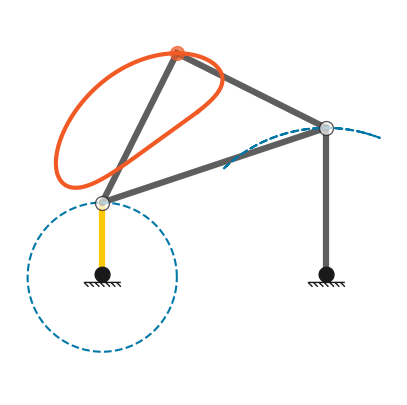

In [53]:
visualizer = MechanismVisualizer()

# Define the variables for the mechanism
x0 = np.array([[0.3,0.2],
               [0.6,0.2],
               [0.3,0.3],
               [0.6,0.4],
               [0.4,0.5]])

# Define the connectivity of the mechanism
edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [3,4]])

# Define the fixed nodes
fixed_joints = np.array([0,1])

# actuator
motor = np.array([0,2])

plt.figure(figsize=(5,5))
visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

This is the first solution from the my_submission file that I am testing 

<Axes: >

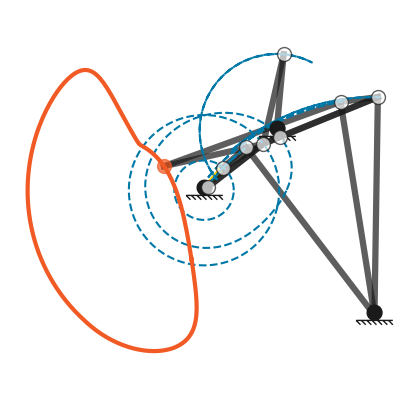

In [89]:
visualizer = MechanismVisualizer()

# Define the variables for the mechanism
x0 = np.array([[0.15638171, 0.69531615],
       [0.18969275, 0.73458471],
       [0.45162064, 0.47875651],
       [0.28209933, 0.79813757],
       [0.22926976, 0.76935487],
       [0.25902701, 0.7754986 ],
       [0.45752778, 0.8565962 ],
       [0.28778487, 0.78779444],
       [0.16248133, 0.7009184 ],
       [0.29433708, 0.93088887],
       [0.3929431 , 0.8483525 ],
       [0.08704113, 0.73685067]])

# Define the connectivity of the mechanism
edges = np.array([[ 0,  1],
       [ 1,  4],
       [ 2,  4],
       [ 0,  5],
       [ 1,  5],
       [ 2,  6],
       [ 5,  6],
       [ 5,  7],
       [ 6,  7],
       [ 0,  8],
       [ 5,  8],
       [ 3,  9],
       [ 5,  9],
       [ 2, 10],
       [ 6, 10],
       [ 5, 11],
       [10, 11]])

# Define the fixed nodes
fixed_joints = np.array([0, 2, 3])

# actuator
motor = np.array([0,1])

plt.figure(figsize=(5,5))
visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

The `MechanismVisualizer` class will solve the mechanism everytime. But if we want to access the full simulations of the mechanisms we will need to use another class, the `MechanismSolver` class. Below is an example of this:

In [90]:
from LINKS.Kinematics import MechanismSolver

In [91]:
solver = MechanismSolver(
    device = 'cpu' # device to run the simulation on (cpu or gpu)
)

solution = solver(x0, edges, fixed_joints, motor)

print("The shape of the solution is:", solution.shape)  # Should be (num_joints, timesteps, 2)

The shape of the solution is: (12, 200, 2)


We can grab joint 4's solution and visualize it:

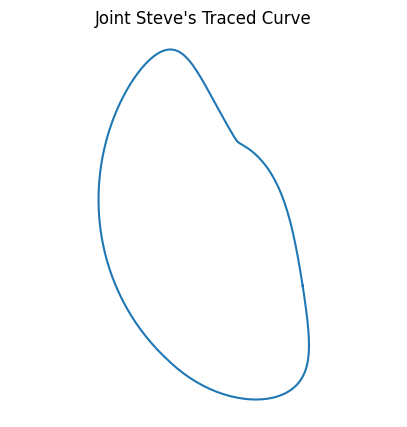

In [92]:
# the target joints solution
traced_curve = solution[-1]  # Joint 4's trajectory over time

plt.figure(figsize=(5,5))
plt.plot(traced_curve[:,0], traced_curve[:,1])
plt.axis('equal')
plt.title("Joint Steve's Traced Curve")
plt.axis('off')
plt.show()

Now that we have a traced curve, how do we compare with the target curve? To do this we provide another class called `CurveEngine` which has some useful functions which you can use to do this.

In [93]:
from LINKS.Geometry import CurveEngine

The functions that we most case about are the `compare_curves` and `visualize_comparison`, and `visualize_alignment`.

In [94]:
curve_processor = CurveEngine(
    normalize_scale=False, # do not normalize the scale of the curve (This would mean we care about the size of the curve too!)
    device='cpu'
)

Now let's visualize the alignment process:

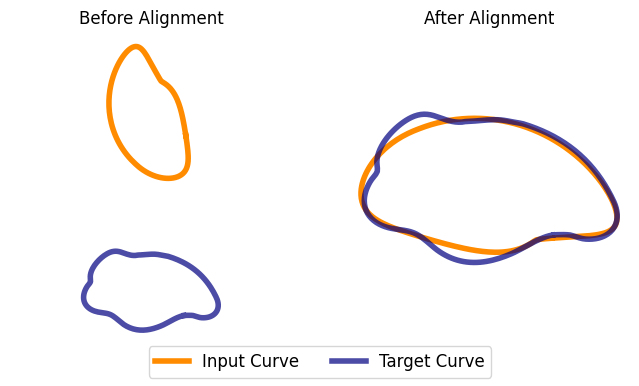

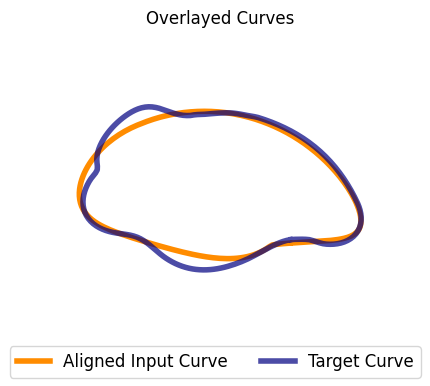

In [76]:
curve_processor.visualize_alignment(traced_curve, target_curves[1])
curve_processor.visualize_comparison(traced_curve, target_curves[1])

Note that the visualizations and calculations can be done for a batch of inputs as well:

In [95]:
distances = curve_processor.compare_curves(
            traced_curve[None].repeat(target_curves.shape[0], axis=0), # repeat the traced curve for each target curve
            target_curves)

print("Distances to all target curves:", distances)

Distances to all target curves: [1.0916953 0.2925812 1.5639637 1.539031  1.1538901 1.4694221]


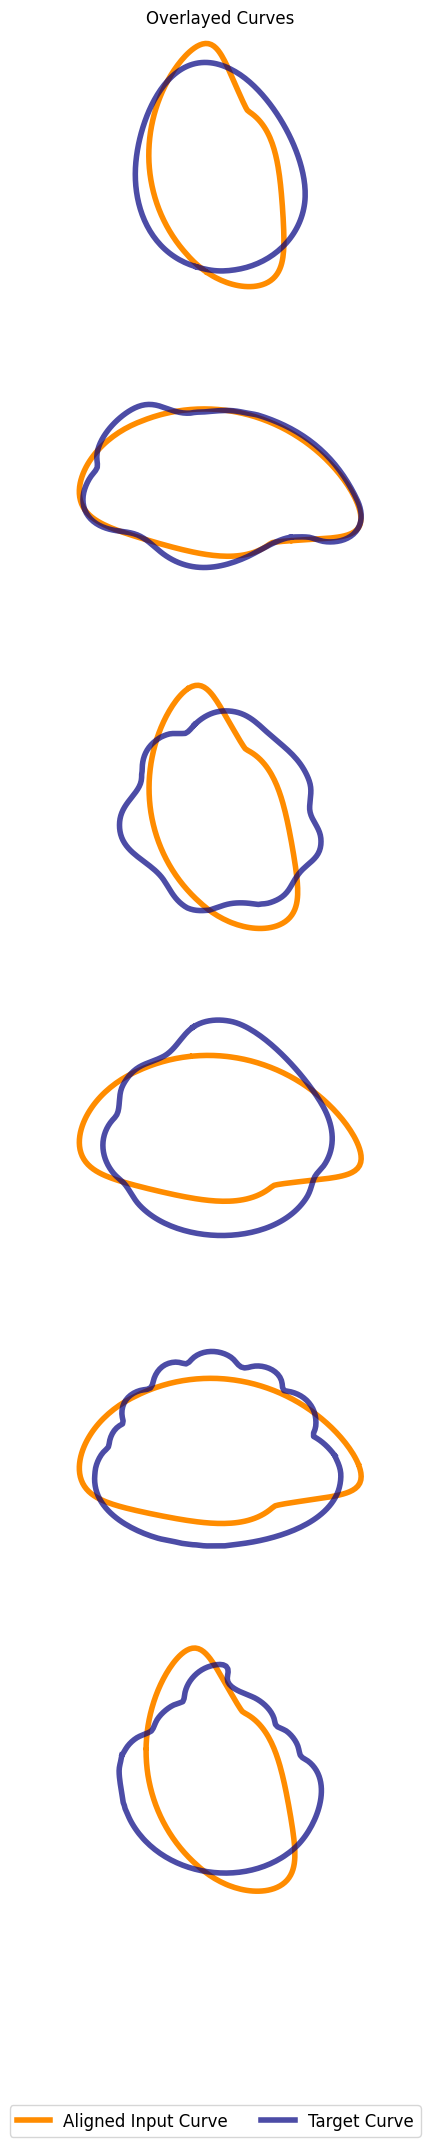

In [96]:
curve_processor.visualize_comparison(
            traced_curve[None].repeat(target_curves.shape[0], axis=0), # repeat the traced curve for each target curve
            target_curves)

Details on the curve distance calculation can be found at the end of the advanced starter notebook.

## Instructions


[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Distance: </b>Any mechanisms output with a distance to the target curve larger than 0.75 will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 10.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 joints </li>
</ul>

Submitted mechanisms that violate these constraints will not be scored.

Your performance on the targets will be measured based on the hypervolume calculated from the population with a reference point of 0.75 for distance and 10.0 for material use. Note that we limit the number of mechanisms you are permitted to submit as potential solutions for any given curve to 1000. The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all target curves.

## Starter Code: Setting up Multi-Objective Optimization With Constraints Using Pymoo

Now that we have established the details to the project lets set up the problem in Pymoo and run an example. Here we will also discuss how your submissions are going to be evaluated to get your final score. Before that, we will introduce a possible approaches for solving this problem. We will use a GA optimizer availabe through the pymoo package. This approach will be a simple approach to only optimize the positions of a given mechanism (We provide this) and the more comprehensive aproach will be one of allowing the GA to generate the full structure of mechanisms which is discussed in the advanced notebook and not here.

For this example we provide you with a mechanism structure to use. A bit more complex than the four-bar above to have a better chance at meeting our constraints. This mechanism is in a file called '`starter_mechanism.npy`'. Let's see what this looks like:

<Axes: >

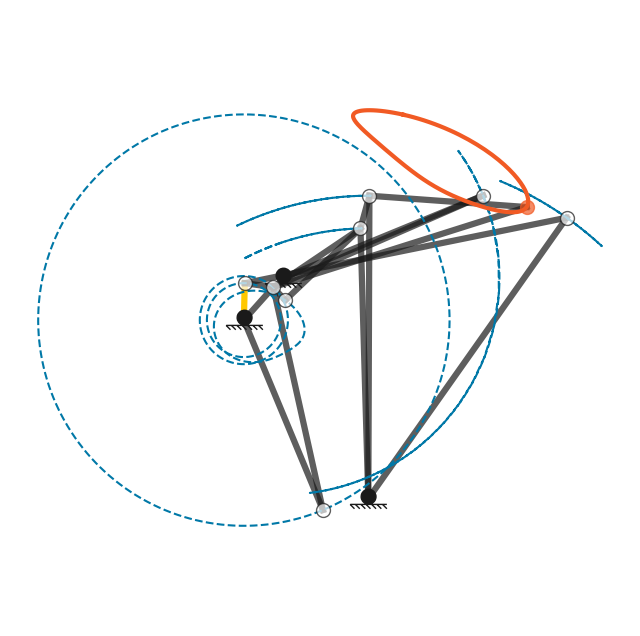

In [ ]:
# starter_mech = np.load('starter_mechanism.npy',allow_pickle=True).item() #Load mechanism

# x0 = starter_mech['x0']
# edges = starter_mech['edges']
# fixed_joints = starter_mech['fixed_joints']
# motor = starter_mech['motor']

# plt.figure(figsize=(8,8))
# visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

<Axes: >

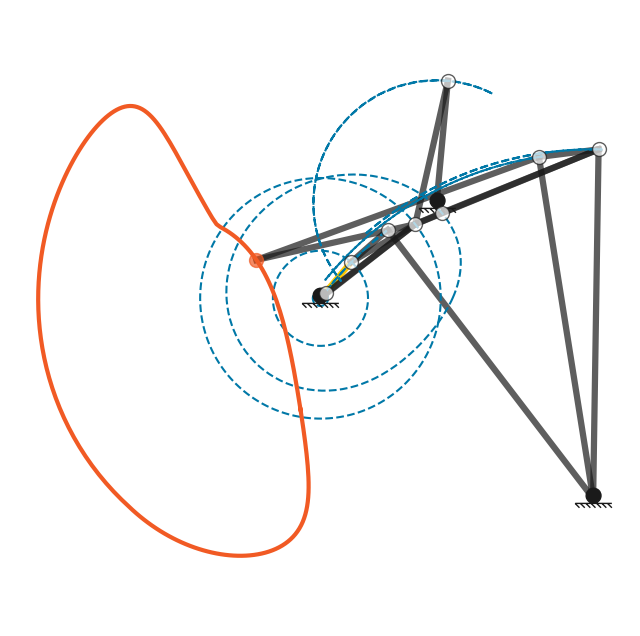

In [97]:
#this is my test from the my_subission file first solution that I loaded above 

x0 = np.array([[0.15638171, 0.69531615],
       [0.18969275, 0.73458471],
       [0.45162064, 0.47875651],
       [0.28209933, 0.79813757],
       [0.22926976, 0.76935487],
       [0.25902701, 0.7754986 ],
       [0.45752778, 0.8565962 ],
       [0.28778487, 0.78779444],
       [0.16248133, 0.7009184 ],
       [0.29433708, 0.93088887],
       [0.3929431 , 0.8483525 ],
       [0.08704113, 0.73685067]])

# Define the connectivity of the mechanism
edges = np.array([[ 0,  1],
       [ 1,  4],
       [ 2,  4],
       [ 0,  5],
       [ 1,  5],
       [ 2,  6],
       [ 5,  6],
       [ 5,  7],
       [ 6,  7],
       [ 0,  8],
       [ 5,  8],
       [ 3,  9],
       [ 5,  9],
       [ 2, 10],
       [ 6, 10],
       [ 5, 11],
       [10, 11]])

# Define the fixed nodes
fixed_joints = np.array([0, 2, 3])

# actuator
motor = np.array([0,1])

plt.figure(figsize=(8,8))
visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

Besides this starter mechanism, we provide two additional classes called `DifferentiableTools` and `Tools`, which provide you with helpful optimization for this problem. As the names suggest the `DifferentiableTools` provides gradients, if you wish to use gradient based optimization and `Tools` will simply provide the values for the objective functions. Both methods have a `compile` function which will compile the functions for faster and more efficient runs. if you use compile the first run will be slow but then the subsequent runs will speed up. Let's see how they work:

In [98]:
from LINKS.Optimization import DifferentiableTools, Tools

In [99]:
optimization_tools = Tools(
    device='cpu' # device to run the optimization on
)
optimization_tools.compile() # compile the functions for faster runs

gradient_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)
gradient_tools.compile() # compile the functions for faster runs

Let's now see how this mechanism does with target curve 2:

In [100]:
distance, material = optimization_tools(x0,
                                        edges,
                                        fixed_joints,
                                        motor,
                                        target_curves[1],
                                        target_idx=None # if you do not specify a target node index, it will automatically use the most complex joint (the last joint in our case)
                                    ) 

print(f"Distance to target curve 2: {distance:.4f}")
print(f"Material used: {material:.4f}")

Distance to target curve 2: 0.2926
Material used: 5.7035


In [101]:
distance, material, distance_grad, material_grad = gradient_tools(x0,
                                        edges,
                                        fixed_joints,
                                        motor,
                                        target_curves[1],
                                        target_idx=None
                                    )

print(f"Distance to target curve 2: {distance:.4f}")
print(f"Material used: {material:.4f}")
print(f"Distance Gradient:\n {distance_grad}\n")
print(f"Material Gradient:\n {material_grad}\n")

Distance to target curve 2: 0.2926
Material used: 5.7035
Distance Gradient:
 [array([9.694769, 7.666404], dtype=float32), array([-0.499403  ,  0.42363942], dtype=float32), array([0.1718795 , 0.10746819], dtype=float32), array([0., 0.], dtype=float32), array([0., 0.], dtype=float32), array([ -9.384557, -10.948577], dtype=float32), array([-1.1756916,  5.982813 ], dtype=float32), array([0., 0.], dtype=float32), array([0., 0.], dtype=float32), array([0., 0.], dtype=float32), array([ 1.051014 , -5.7086062], dtype=float32), array([0.14199066, 2.4768605 ], dtype=float32)]

Material Gradient:
 [array([-4.34289, -4.10925], dtype=float32), array([-1.9311956, -0.8112788], dtype=float32), array([ 1.4976746, -5.5633936], dtype=float32), array([-0.18359268, -1.9915557 ], dtype=float32), array([0.28716683, 2.9084    ], dtype=float32), array([2.6990964 , 0.41581511], dtype=float32), array([5.7201405, 3.760681 ], dtype=float32), array([-0.01456642,  0.03498173], dtype=float32), array([-0.10976124,  0.1

**NOTE:** Both of these classes accept batches of mechanisms for a single target curve. If you pass batches, this will be alot faster, especially running on gpu. In this code to keep things simple we do `ElementwiseProblem` in pymoo, but pymoo supports vectorized problems with the `Problem` class.

Now we will use an approach similar to the demo to define our problem. Note that here we will also add consraints to the problem to remove unacceptable mechanisms (Distance above 0.75 and material more than 10.0):

In [102]:
# pymoo imports
from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

In [103]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_Synthesis_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self, edges, fixed_joints, motor, target_curve):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = x0.shape[0] * 2, n_obj=2, n_constr=2, xl=0.0, xu=5.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.edges = edges
        self.fixed_joints = fixed_joints
        self.motor = motor
        self.N = x0.shape[0]

        # Store the target
        self.target_curve = target_curve
        
    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                self.edges,
                                self.fixed_joints,
                                self.motor,
                                self.target_curve,
                                target_idx=None # if you do not specify a target node index, it will automatically use the most complex joint (the last joint in our case)
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0

Now we will run NSGA-II on this problem. Note that the code below replaces the sampling of the algorithm with the initial positions of the pre-defined mechanism. This is an example of population initialization. Becuase this mechanism skeleton is bigger the GA usually struggles to find any valid solutions so this will help start with a better population. This will be discussed in more detail in the advanced notebook. For now let's run this on the first curve:

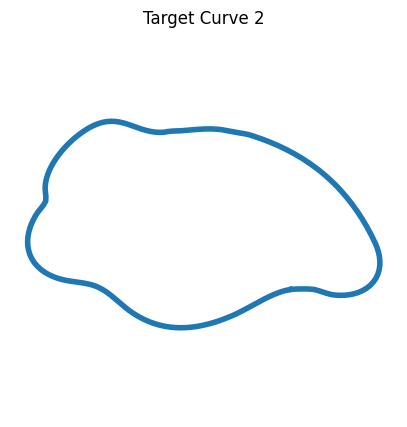

In [104]:
target_index = 1
target_curve = np.array(target_curves[target_index])
plt.figure(figsize=(5,5))
plt.plot(target_curve[:,0],target_curve[:,1], lw=4)
plt.axis('equal')
plt.axis('off')
plt.title(f'Target Curve {target_index + 1}')
plt.show()

In [105]:
# trying this run on the best solution from the first run below
problem = mechanism_Synthesis_optimization(
    edges,
    fixed_joints,
    motor,
    target_curve
)

# Algorith Parameters
population_size = 120
num_generations = 200

# Initialize a population of duplicates
X = x0[None].repeat(120, axis=0).reshape(population_size, -1)

# Setup the algorithm
algorithm = NSGA2(pop_size=population_size,
                    sampling=X,
                    crossover=SBX(prob=0.9, eta=5.0),
                    mutation=PolynomialMutation(eta=5.0, prob=0.02),
                    eliminate_duplicates=True)

results = minimize(problem,
                   algorithm,
                   ('n_gen', num_generations),
                   verbose=True,
                   save_history=True,
                   seed=0,
                  )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       91 |      1 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     3 |      211 |      3 |  0.000000E+00 |           INF |  0.0975130032 |         ideal
     4 |      331 |      4 |  0.000000E+00 |  0.0752896910 |  0.2528968616 |         ideal
     5 |      451 |      5 |  0.000000E+00 |  0.000000E+00 |  0.2013975071 |         ideal
     6 |      571 |      9 |  0.000000E+00 |  0.000000E+00 |  0.9723158555 |         nadir
     7 |      691 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0333295841 |         nadir
     8 |      811 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0292664645 |         ideal
     9 |      931 |     12 |  0.000000E+00 |  0.000000E+00 |  0.1798762737 |         ideal
    10 |     1051 |     14 |  0.000000E+00 |  0.000000E+00 |  0.1289593690 |         nadir

In [ ]:
# #first attempt that got me 2.18 hypervolume on egg 2 I took the first solution from the large array of potential solutions saved in my_submission 
# problem = mechanism_Synthesis_optimization(
#     edges,
#     fixed_joints,
#     motor,
#     target_curve
# )

# # Algorith Parameters
# population_size = 120
# num_generations = 650

# # Initialize a population of duplicates
# X = x0[None].repeat(120, axis=0).reshape(population_size, -1)

# # Setup the algorithm
# algorithm = NSGA2(pop_size=population_size,
#                     sampling=X,
#                     crossover=SBX(prob=0.9, eta=5.0),
#                     mutation=PolynomialMutation(eta=5.0, prob=0.02),
#                     eliminate_duplicates=True)

# results = minimize(problem,
#                    algorithm,
#                    ('n_gen', num_generations),
#                    verbose=True,
#                    save_history=True,
#                    seed=0,
#                   )


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  5.0903553963 |  5.0903553963 |             - |             -
     2 |       91 |      1 |  3.7726492882 |           INF |             - |             -
     3 |      211 |      1 |  3.7726492882 |  5.8691532503 |             - |             -
     4 |      331 |      1 |  3.2320997715 |  4.7909312318 |             - |             -
     5 |      451 |      1 |  2.8169747591 |  4.2846277843 |             - |             -
     6 |      571 |      1 |  2.2906194925 |  3.6981123964 |             - |             -
     7 |      691 |      1 |  0.8851063251 |  3.0551253637 |             - |             -
     8 |      811 |      1 |  0.5407624245 |  2.5728437424 |     

Let's visualize the non-dominated solution found by the GA:

In [106]:
from LINKS.Visualization import GAVisualizer

Hyper Volume ~ 2.184832


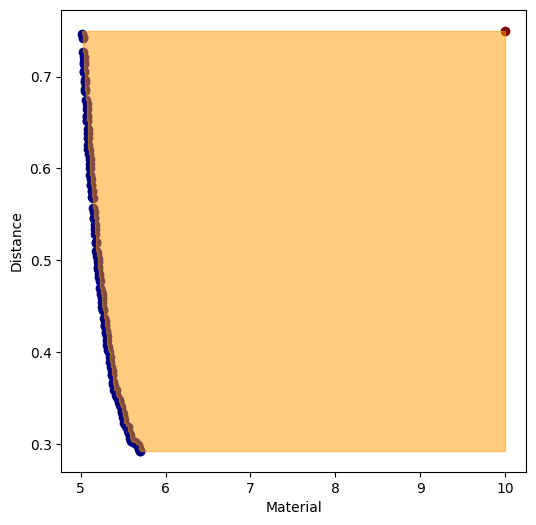

In [ ]:
# #first run results 
# from pymoo.indicators.hv import HV
# ga_visualizer = GAVisualizer()

# if not results.X is None:
#     #Specify reference point
#     ref_point = np.array([0.75, 10.0])

#     #Calculate Hypervolume
#     ind = HV(ref_point)
#     hypervolume = ind(results.F)

#     #Print and plot
#     print('Hyper Volume ~ %f' %(hypervolume))
#     ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
# else:
#     print('Did Not Find Solutions!!')

Hyper Volume ~ 2.077938


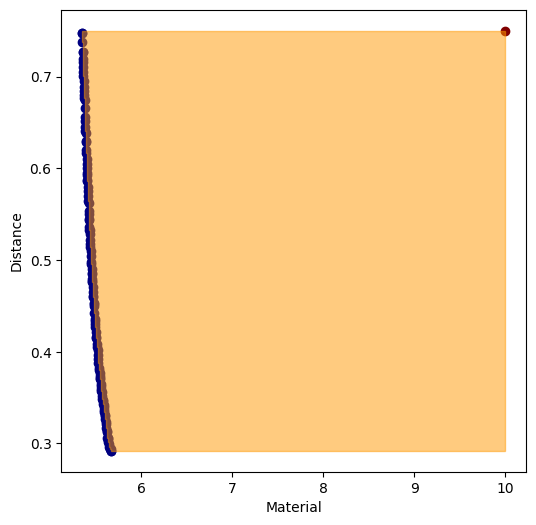

In [107]:
# second run results starting from one of the best solutions from the first run
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

Now Let's visualize the best solution for distance

In [25]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,0])
        best_sol = results.X[best_idx].reshape(-1,2) # get the solution with the lowest distance to target curve (and reshape it)
    else:
        best_sol = results.X.reshape(-1,2)
else:
    print('Did Not Find Solutions!!')

Distance: 0.7469, Material: 5.0213


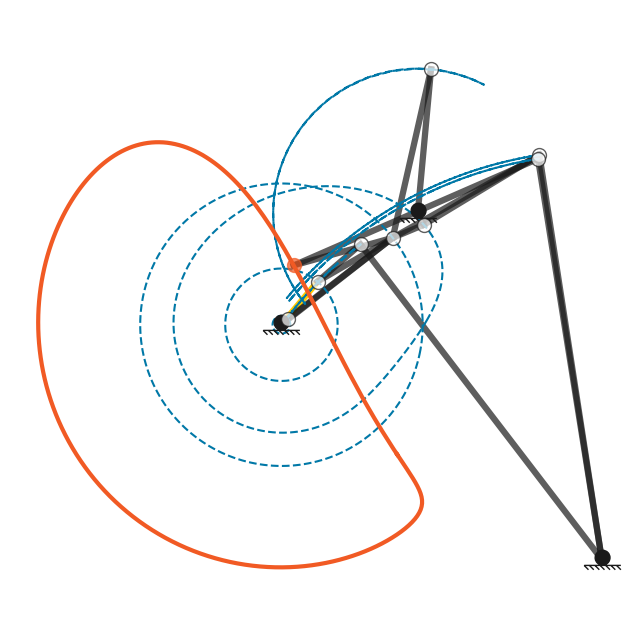

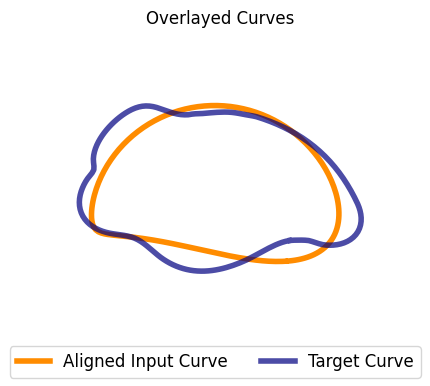

In [31]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[-1]
curve_processor.visualize_comparison(
    traced_curve,
    target_curves[target_index]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

Now let's visualize the best solution for material

In [32]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,1])
        best_sol = results.X[best_idx].reshape(-1,2) # get the solution with the lowest distance to target curve (and reshape it)
    else:
        best_sol = results.X.reshape(-1,2)
else:
    print('Did Not Find Solutions!!')

Distance: 0.7469, Material: 5.0213


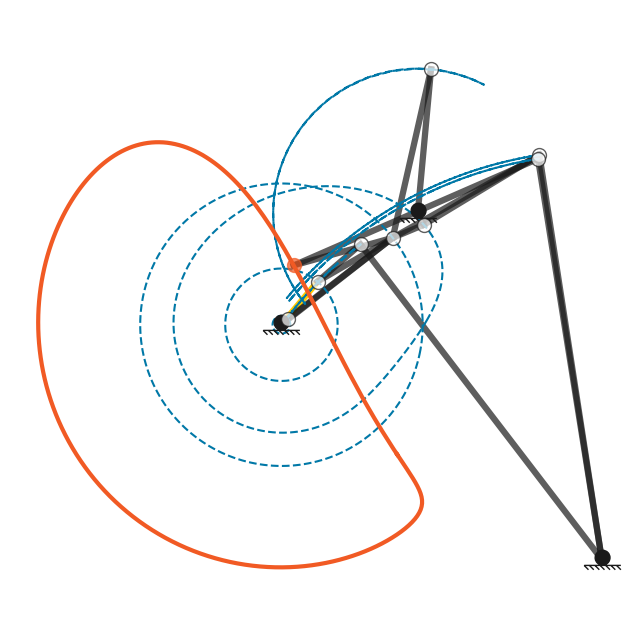

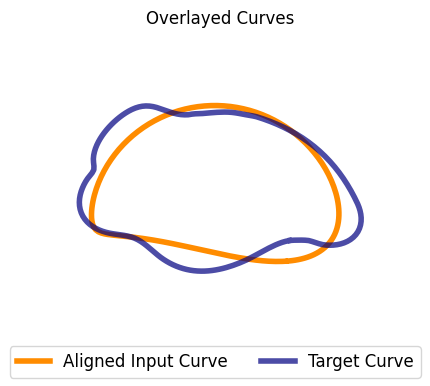

In [33]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[-1]
curve_processor.visualize_comparison(
    traced_curve,
    target_curves[target_index]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

### Submission Format
We want you to submit a single numpy file which includes your solutions to each of the 6 problems. This numpy file will be a standard python dictionary with following format:

```python
submission = {
    'Problem 1': [
        {
            'x0': np.ndarray of shape (N, 2),
            'edges': np.ndarray of shape (E, 2),
            'fixed_joints': np.ndarray of shape (F,),
            'motor': np.ndarray of shape (2,),
            'target_joint': int index of the target node

        },
        ...
    ]
    'Problem 2': [...],
    ...
    'Problem 6':[...],
}
```

To make things a bit easier for you, we have provided a few helper functions which will create this dictionary for you. Also note that if you do not provide `target_joint`, during evaluation we will automatically pick the most complex joint (highest index) for evaluation, so be careful to include that if your optimizer picked joints. Finally, if any of the problems are not in your submission dictionary or if the list in the dictionary is empty, a hypervolume of 0 will be assigned to that problem. Your final score is the average hypervolume across all 6 problems.

Let's use the solution of problem 1 that we just made to make a submission:

In [34]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

print("Empty Submission:", submission)

Empty Submission: {'Problem 1': [], 'Problem 2': [], 'Problem 3': [], 'Problem 4': [], 'Problem 5': [], 'Problem 6': []}


In [35]:
# add out population to submission
if not results.X is None:
    for i in range(results.X.shape[0]):
        x0_member = results.X[i].reshape(-1,2)
        
        mech = {
            'x0': x0_member,
            'edges': edges,
            'fixed_joints': fixed_joints,
            'motor': motor,
            'target_joint': None # None means it will automatically use the most complex joint (the last joint in our case)
        }
        
        submission['Problem 2'].append(mech)

In [36]:
print(submission)

{'Problem 1': [], 'Problem 2': [{'x0': array([[0.15638171, 0.69531615],
       [0.18969275, 0.73458471],
       [0.45162064, 0.47875651],
       [0.28209933, 0.79813757],
       [0.22926976, 0.76935487],
       [0.25902701, 0.7754986 ],
       [0.45752778, 0.8565962 ],
       [0.28778487, 0.78779444],
       [0.16248133, 0.7009184 ],
       [0.29433708, 0.93088887],
       [0.3929431 , 0.8483525 ],
       [0.08704113, 0.73685067]]), 'edges': array([[ 0,  1],
       [ 1,  4],
       [ 2,  4],
       [ 0,  5],
       [ 1,  5],
       [ 2,  6],
       [ 5,  6],
       [ 5,  7],
       [ 6,  7],
       [ 0,  8],
       [ 5,  8],
       [ 3,  9],
       [ 5,  9],
       [ 2, 10],
       [ 6, 10],
       [ 5, 11],
       [10, 11]]), 'fixed_joints': array([0, 2, 3]), 'motor': [0, 1], 'target_joint': None}, {'x0': array([[0.15639746, 0.6953192 ],
       [0.18969355, 0.73503847],
       [0.4518204 , 0.47880444],
       [0.28209933, 0.79813757],
       [0.22932267, 0.76931762],
       [0.2590270

Now let's get our score:

In [37]:
evaluate_submission(submission)

{'Overall Score': 0.36413282710763184,
 'Score Breakdown': {'Problem 1': 0.0,
  'Problem 2': 2.184796962645791,
  'Problem 3': 0.0,
  'Problem 4': 0.0,
  'Problem 5': 0.0,
  'Problem 6': 0.0}}

We can also visualize the non-dominated samples in the submission population (it will take a while since we have alot of samples to visualize):

In [ ]:
ga_visualizer.plot_pareto_efficient(
    F=results.F,
    population=submission['Problem 2'],
    target_curve=target_curve,
    objective_labels=['Distance', 'Material']
)

In your submission we expect a single numpy file. Below is some code to save this submission as a numpy file:

In [38]:
np.save('my_submission.npy', submission) # This will save your submission in the current directory

In [40]:
my_submission = np.load('my_submission.npy', allow_pickle=True) 
print(my_submission)# Load your submission

{'Problem 1': [], 'Problem 2': [{'x0': array([[0.15638171, 0.69531615],
       [0.18969275, 0.73458471],
       [0.45162064, 0.47875651],
       [0.28209933, 0.79813757],
       [0.22926976, 0.76935487],
       [0.25902701, 0.7754986 ],
       [0.45752778, 0.8565962 ],
       [0.28778487, 0.78779444],
       [0.16248133, 0.7009184 ],
       [0.29433708, 0.93088887],
       [0.3929431 , 0.8483525 ],
       [0.08704113, 0.73685067]]), 'edges': array([[ 0,  1],
       [ 1,  4],
       [ 2,  4],
       [ 0,  5],
       [ 1,  5],
       [ 2,  6],
       [ 5,  6],
       [ 5,  7],
       [ 6,  7],
       [ 0,  8],
       [ 5,  8],
       [ 3,  9],
       [ 5,  9],
       [ 2, 10],
       [ 6, 10],
       [ 5, 11],
       [10, 11]]), 'fixed_joints': array([0, 2, 3]), 'motor': [0, 1], 'target_joint': None}, {'x0': array([[0.15639746, 0.6953192 ],
       [0.18969355, 0.73503847],
       [0.4518204 , 0.47880444],
       [0.28209933, 0.79813757],
       [0.22932267, 0.76931762],
       [0.2590270

You can call the `evaluate_submission` functions with file paths too:

In [ ]:
evaluate_submission(
    submission='my_submission.npy',
    target_curves='target_curves.npy'
)

{'Overall Score': 0.20071005683320445,
 'Score Breakdown': {'Problem 1': 1.2042603409992267,
  'Problem 2': 0.0,
  'Problem 3': 0.0,
  'Problem 4': 0.0,
  'Problem 5': 0.0,
  'Problem 6': 0.0}}

When you are submitting to the scoreboard you will need to upload the submission numpy file.

### Let's get a full submission going
Now we will run the GA for each target curve seperately and get a full submission going:

Optimizing for Problem 1, Please Wait...
Optimizing for Problem 2, Please Wait...
Optimizing for Problem 3, Please Wait...
Optimizing for Problem 4, Please Wait...
Optimizing for Problem 5, Please Wait...
Optimizing for Problem 6, Please Wait...


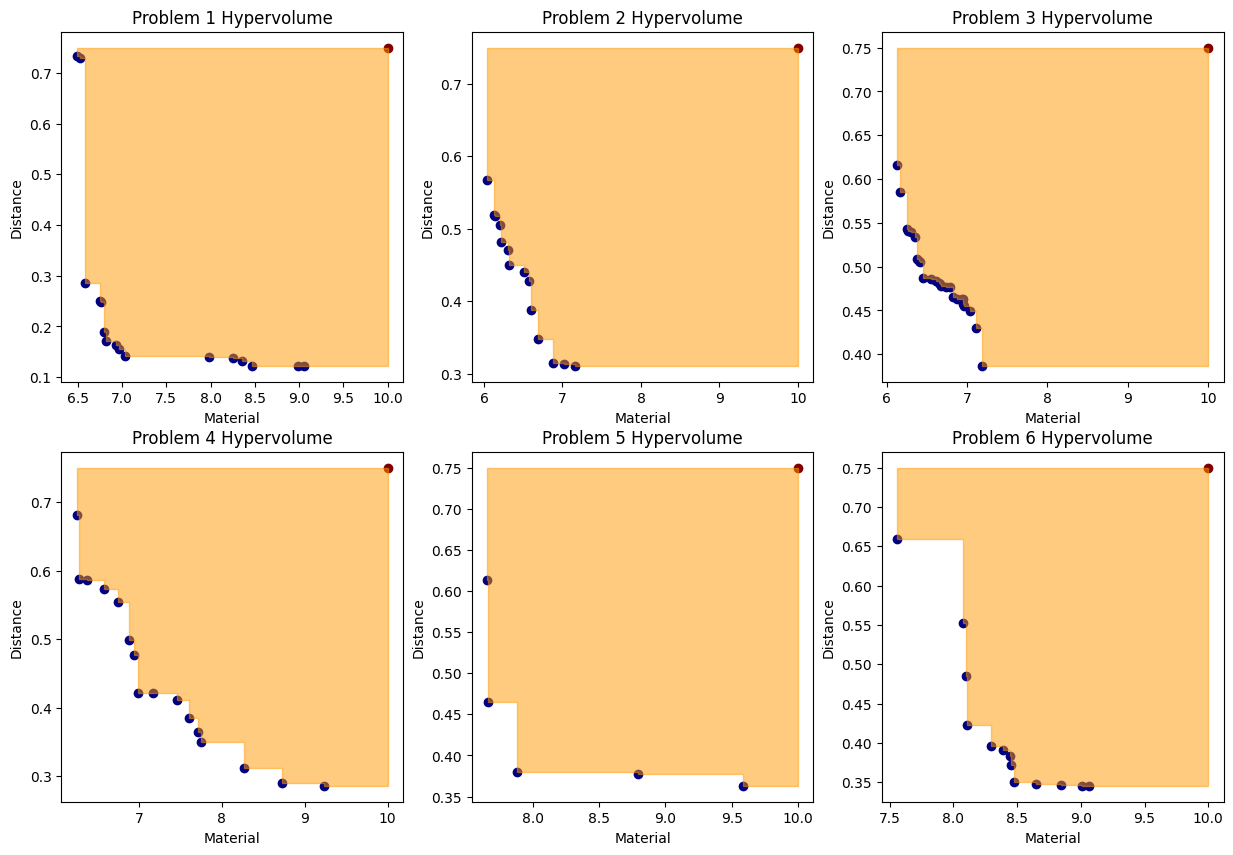

In [ ]:
submission = make_empty_submission()
full_results = submission.copy()

population_size = 200
num_generations = 50

for i in range(len(target_curves)):
    
    print(f"Optimizing for Problem {i+1}, Please Wait...")
    
    problem = mechanism_Synthesis_optimization(
        edges,
        fixed_joints,
        motor,
        target_curves[i]
    )
    
    X = x0[None].repeat(population_size, axis=0).reshape(population_size, -1)
    # Setup the algorithm
    algorithm = NSGA2(pop_size=population_size,
                        sampling=X,
                        crossover=SBX(prob=1.0, eta=3.0),
                        mutation=PolynomialMutation(eta=3.0, prob=0.9),
                        eliminate_duplicates=True)

    results = minimize(problem,
                    algorithm,
                    ('n_gen', num_generations),
                    verbose=False,
                    save_history=True,
                    seed=123,
                    )
    
    if results.X is None:
        print('Did Not Find Solutions!!')
    else:
        for j in range(results.X.shape[0]):
            x0_member = results.X[j].reshape(-1,2)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                'target_joint': None # None means it will automatically use the most complex joint (the last joint in our case)
            }

            submission[f'Problem {i+1}'].append(mech)
            full_results[f'Problem {i+1}'] = results


# now let's evaluate the pareto efficient solutions for all problems
plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(target_curves)):
    if isinstance(full_results[f'Problem {i+1}'], list) or full_results[f'Problem {i+1}'].X is None:
        print(f'Did Not Find Solutions for Problem {i+1}!!')
        plt.subplot(2, 3, i+1)
        plt.text(0.5, 0.5, 'No Solutions Found', horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')
        continue
    ga_visualizer.plot_HV(
        F=full_results[f'Problem {i+1}'].F,
        ref=np.array([0.75, 10.0]),
        ax=plt.subplot(2, 3, i+1),
        objective_labels=['Distance', 'Material']
    )
    plt.title(f'Problem {i+1} Hypervolume')

In [ ]:
evaluate_submission(submission)

{'Overall Score': 1.3392431216636094,
 'Score Breakdown': {'Problem 1': 2.0762848605094746,
  'Problem 2': 1.6275143085831445,
  'Problem 3': 1.2924261160987953,
  'Problem 4': 1.3881146582029658,
  'Problem 5': 0.8565706125076957,
  'Problem 6': 0.7945481740795799}}

Now we can save this submission and submit it to the leader board.

In [ ]:
np.save('my_full_submission.npy', submission) # This will save your submission in the current directory

<H1>Leader Board: </H1>
You can submit your numpy files to the leaderboard and see how you are doing compared to others. 
The leaderboard can be found at:

[https://design-ai.mit.edu/CP1/](https://design-ai.mit.edu/CP1/)